In [1]:
import pandas as pd
import numpy as np
from invertiblewavelets import Transform
import matplotlib.pyplot as plt
from invertiblewavelets import *
from scipy import signal
from scipy.ndimage import label, binary_closing, gaussian_filter1d, binary_dilation

In [2]:
wavelet_obj = Morlet(1,15)

#### Load Example Data from Swarm A Spacecraft Magnetoemter

In [42]:
"Load Data"
data = np.load("data.npy")

# Adding some noise
sample_rate = 50.0                          # 50 Hz sampling rate
num_samples = data.shape[-1]                # 5000 samples
t = np.arange(num_samples) / sample_rate    # time array
B1 = data + 100 * np.sin(2 * np.pi * 5 * t)
B2 = data + 50 * np.sin(2 * np.pi * 5 * t)
B = np.vstack((B1,B2))

"Wavelet Transform"
transform = Transform(
    data=data,
    fs = sample_rate,
    wavelet=wavelet_obj, # Wavelet to use
    #pad_method=None, # Padding method for the convolution calls np.pad. Set to None if no padding
    Mc = 1,
    b = 1,
    q =20
)

transform.enforce_orthagonality(1e-1)

"Perform forward wavelet transform"
w1 = transform.forward(B[0]).real
w2 = transform.forward(B[1]).real


D = w2 - w1  # shape (J, T), complex

# 1) correlations (eqs 6–7), using conjugate inner products
C1 = np.sum( D *w1, axis=1 )   # shape (J,)
C2 = np.sum( D *w2, axis=1 )   # shape (J,)

# 2) gain estimate K̂ per scale (eq 8)
K_hat = np.abs(C2 / C1)                          # shape (J,)

# 3) Coherence Filter
C12 = np.sum(w1 * np.conj(w2), axis=1)    # shape (J,)
# auto‐spectra
P1 = np.sum(np.abs(w1)**2, axis=1)        # shape (J,)
P2 = np.sum(np.abs(w2)**2, axis=1)        # shape (J,)
C = np.abs(C12)**2 / (P1 * P2)

mask = C > 0.9

# 4) ambient‑field estimate X(s,τ) (eq 10)
a = 1e-8
w_clean = (w1 + w2) / 2
w_clean[mask] = (K_hat[mask,None]*w1[mask] - w2[mask]) / (K_hat[mask,None] - 1) 


result = transform.inverse(np.copy(w_clean))
print(np.sqrt(np.mean((data[200:-200]-result[200:-200])**2)))

%matplotlib qt5
fig, ax = plt.subplots(3,1)
ax[0].plot(K_hat, label='K')
ax[0].legend()
ax[1].plot(B[0])
ax[1].plot(data)
ax[2].plot(result)
ax[2].plot(data)


4647129910.401807


In [23]:
C12 = np.sum(w1 * np.conj(w2), axis=1)    # shape (J,)
# auto‐spectra
P1 = np.sum(np.abs(w1)**2, axis=1)        # shape (J,)
P2 = np.sum(np.abs(w2)**2, axis=1)        # shape (J,)
C = np.abs(C12)**2 / (P1 * P2)

In [40]:
K_hat.shape

(482,)

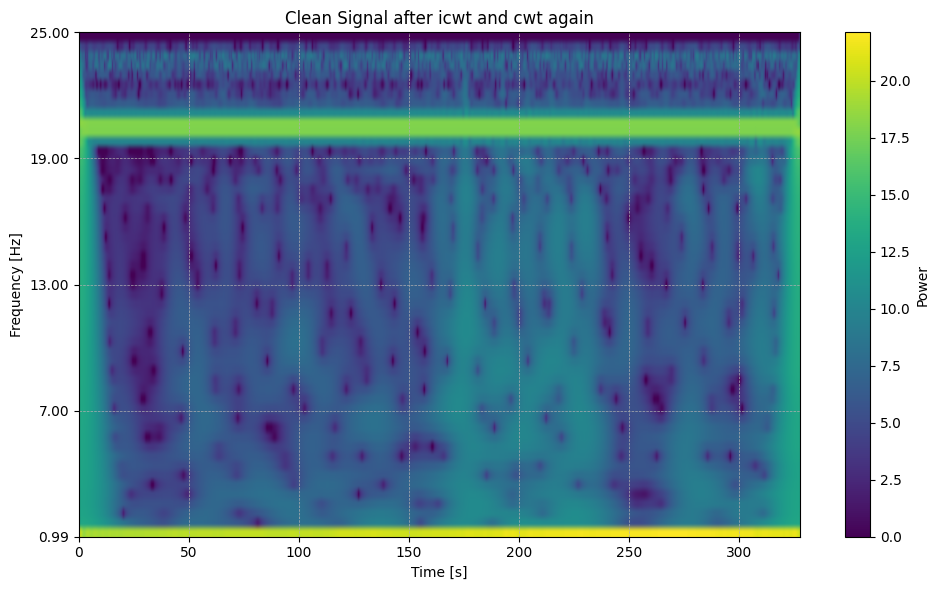

In [6]:
%matplotlib inline
#transform.power_scalogram(w1, vmin=0,  title = 'noisy 1 coeffs')
#transform.power_scalogram(transform.forward(data), vmin=0, title = 'True coeffs')
#transform.power_scalogram(w_clean, vmin=0, title = 'Cleaned Signal coeffs')
w = transform.forward(result)
transform.scalogram(w, vmin=0, title = 'Clean Signal after icwt and cwt again')

'\nThis chart shows from the frequency in the x axis from the np.fft and the wavelet channel in the y axis. The frequency uncertainty grows with scale decrease. The top panel shows the wavelet filterbank, the middle pannel shows cleaned sensor data, and the bottom panel shows the raw filterbank. It appears that the 20 Hz signal is strong outside the frequency band of the corresponding wavelet. This 20 Hz signal can be seen as a vertical stripe in the bottom panel. Why does that signal appear outside of the relevant wavelet band? \n'

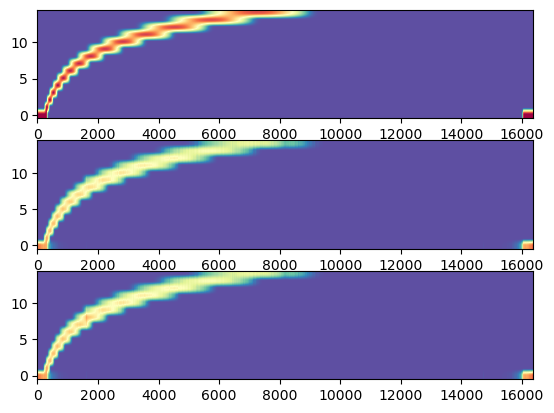

In [51]:
# https://arxiv.org/pdf/2402.16426

fig, ax = plt.subplots(3,1)
ax[0].imshow(np.log(np.abs(transform.Wfreq)+1e-3), aspect='auto', origin='lower', cmap='Spectral_r')
ax[1].imshow(np.log(np.abs(np.fft.fft(w_clean, axis=1)) +1e-3), aspect='auto', origin='lower', cmap='Spectral_r')
ax[2].imshow(np.log(np.abs(np.fft.fft(w1, axis=1)) +1e-3), aspect='auto', origin='lower', cmap='Spectral_r')


"""
This chart shows from the frequency in the x axis from the np.fft and the wavelet channel in the y axis. The frequency uncertainty grows with scale decrease. The top panel shows the wavelet filterbank, the middle pannel shows cleaned sensor data, and the bottom panel shows the raw filterbank. It appears that the 20 Hz signal is strong outside the frequency band of the corresponding wavelet. This 20 Hz signal can be seen as a vertical stripe in the bottom panel. Why does that signal appear outside of the relevant wavelet band? 
"""

c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


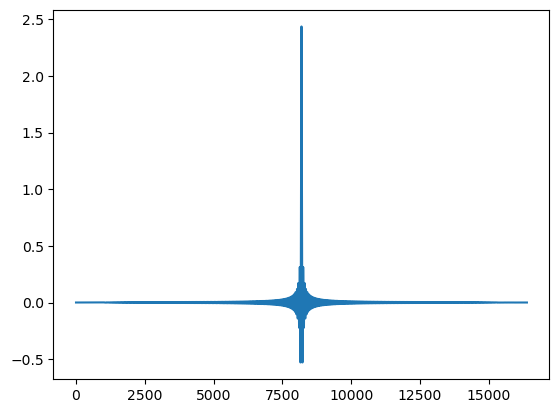

In [47]:
plt.plot(np.fft.ifft(transform.Wfreq[0]/transform.phase_shift))

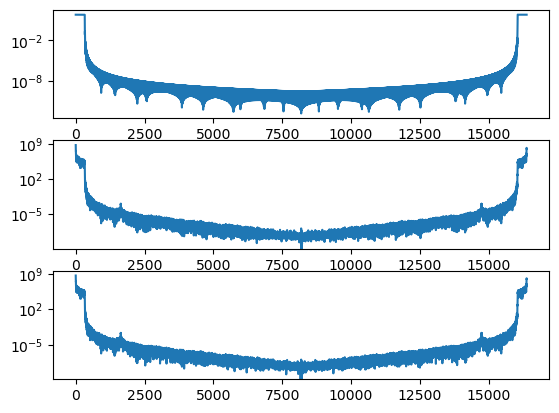

In [48]:
fig, ax = plt.subplots(3,1)
i = 0
ax[0].plot(np.abs(transform.Wfreq[i]))
ax[1].plot(np.abs(np.fft.fft(w_clean, axis=1))[i])
ax[2].plot(np.abs(np.fft.fft(w1, axis=1))[i])
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')

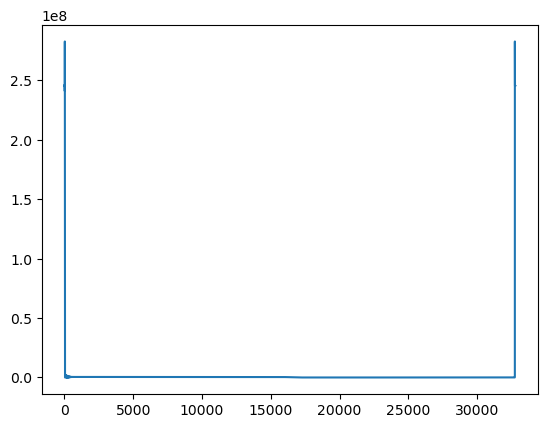

In [8]:
plt.plot(transform.Sfreq)

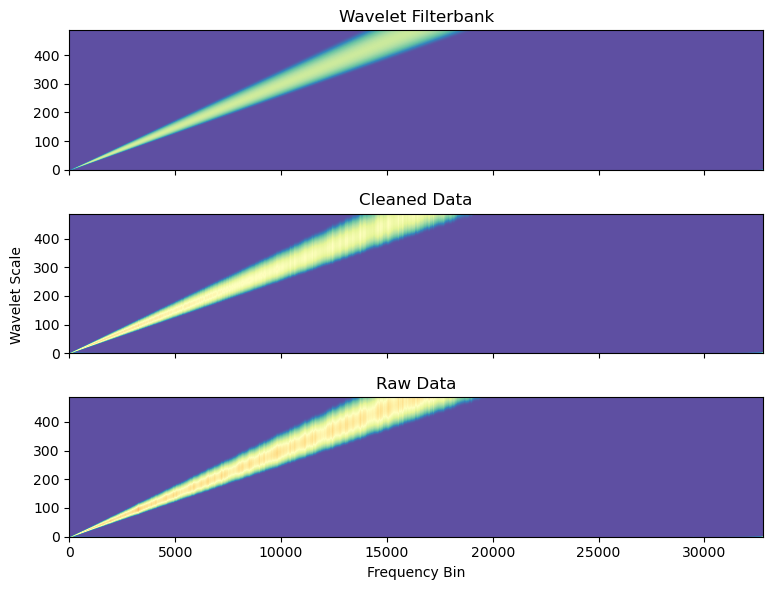

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming transform.Wfreq, w_clean, and w1 are already defined
# and are 2D NumPy arrays with dimensions corresponding to (wavelet_scale, frequency_bin)

# Compute the log magnitude for each dataset
log_Wfreq = np.log(np.abs(transform.Wfreq) + 1e-3)
log_w_clean = np.log(np.abs(np.fft.fft(w_clean, axis=1)) + 1e-3)
log_w1 = np.log(np.abs(np.fft.fft(w1, axis=1)) + 1e-3)

# Determine the common color scale limits
vmin = min(log_Wfreq.min(), log_w_clean.min(), log_w1.min())
vmax = max(log_Wfreq.max(), log_w_clean.max(), log_w1.max())

# Create subplots with shared x and y axes
fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True, sharey=True)

# Define the colormap
cmap = 'Spectral_r'

# Plot each dataset
im0 = axes[0].imshow(log_Wfreq, aspect='auto', origin='lower',
                     cmap=cmap, vmin=vmin, vmax=vmax)
axes[0].set_title('Wavelet Filterbank')

im1 = axes[1].imshow(log_w_clean, aspect='auto', origin='lower',
                     cmap=cmap, vmin=vmin, vmax=vmax)
axes[1].set_title('Cleaned Data')

im2 = axes[2].imshow(log_w1, aspect='auto', origin='lower',
                     cmap=cmap, vmin=vmin, vmax=vmax)
axes[2].set_title('Raw Data')

# Set common labels
axes[2].set_xlabel('Frequency Bin')
fig.text(0.04, 0.5, 'Wavelet Scale', va='center', rotation='vertical')



# Optimize layout
plt.tight_layout(rect=[0.05, 0, 1, 1])

# Display the plots
plt.show()


In [10]:
"""
from wavelets import WaveletAnalysis
w1 = WaveletAnalysis(B[0], dt=1/sample_rate, frequency=True, dj = 1/8, unbias=False, mask_coi = True)
w2 = WaveletAnalysis(B[1], dt=1/sample_rate, frequency=True, dj = 1/8, unbias=False, mask_coi = True)

"Transform signals into wavelet domain"
wn1 = w1.wavelet_transform.real
wn2 = w2.wavelet_transform.real

"Sheinker and Moldwin's Algorithm"
dw = wn2-wn1
wc1 = np.sum(dw*wn1, axis=1)
wc2 = np.sum(dw*wn2, axis=1)
k_hat_real = wc2/wc1
plt.plot(k_hat_real)
"""

'\nfrom wavelets import WaveletAnalysis\nw1 = WaveletAnalysis(B[0], dt=1/sample_rate, frequency=True, dj = 1/8, unbias=False, mask_coi = True)\nw2 = WaveletAnalysis(B[1], dt=1/sample_rate, frequency=True, dj = 1/8, unbias=False, mask_coi = True)\n\n"Transform signals into wavelet domain"\nwn1 = w1.wavelet_transform.real\nwn2 = w2.wavelet_transform.real\n\n"Sheinker and Moldwin\'s Algorithm"\ndw = wn2-wn1\nwc1 = np.sum(dw*wn1, axis=1)\nwc2 = np.sum(dw*wn2, axis=1)\nk_hat_real = wc2/wc1\nplt.plot(k_hat_real)\n'

#### WAICUP


In [11]:
"""
from magprime.algorithms import WAICUP
%matplotlib inline
WAICUP.fs = sample_rate
WAICUP.detrend =True
result_baseline = WAICUP.clean(B, triaxial=False)
print(np.sqrt(((data-result_baseline)**2).mean(axis=0)))
plt.plot(data, label='data')
plt.plot(result, label='result', alpha=0.5)
plt.plot(result_baseline, label='result_baseline', alpha=0.3)
plt.legend()
"""

"\nfrom magprime.algorithms import WAICUP\n%matplotlib inline\nWAICUP.fs = sample_rate\nWAICUP.detrend =True\nresult_baseline = WAICUP.clean(B, triaxial=False)\nprint(np.sqrt(((data-result_baseline)**2).mean(axis=0)))\nplt.plot(data, label='data')\nplt.plot(result, label='result', alpha=0.5)\nplt.plot(result_baseline, label='result_baseline', alpha=0.3)\nplt.legend()\n"